In [8]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency
from scipy import stats
from matplotlib import pyplot as plt

1 Read the dataset 
========

In [9]:
data= pd.read_csv('../../sep19SexAndAgeAddedFINAL DATASET_ver2.txt',sep=',')

data['FIELD_6_7']=np.min(data[['FIELD_6','FIELD_7']],axis=1) #combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)
data=data.drop(columns=['FIELD_6','FIELD_7','B_DAY'])
print(data.shape)

(535169, 404)


In [10]:
# add Class to the dataset 
conditions = [
    (data.L100800 < 100)  ,
    (data.L100800 >= 100) & (data.L100800 < 126),
    (data.L100800 >= 126)]
choices = [0,1,2]
data['CLASS'] = np.select(conditions, choices, default=0) 

In [11]:
# filter the data set 
data=data[data.FIELD_16!=1] # exclude people who are diagnosed for (diabetes) 
data=data[data.FIELD_23!=1] # exclude people who are on medication for diabetes

data=data[data.FIELD_15!=1] # exclude people who are diagnosed for (high blood pressure)
data=data[data.FIELD_22!=1] # exclude people who are on medication for high blood pressure

data=data[data.FIELD_17!=1] # exclude people who are diagnosed for hyperlipidemia
data=data[data.FIELD_24!=1] # exclude people who are on medication for hyperlipidemia
print(data.shape)

(466680, 405)


In [12]:
# rename columns
data.rename(columns={'L104600': 'HBA1C', 
                     'L103000': 'Triglycerides',
                     'L100800':'fasting glucose', 
                     'S000300':'BMI', 
                     'S000501':'SBP', 
                     'S000502':'DBP', 
                     'L101700':'r-GTP gamma', 
                     'L103300':'Cardiac risk factor', 
                     'L190400':'Hemoglobin', 
                     'L190500':'HCT', 
                     'L100700':'Uric Acid', 
                     'L101300':'SGPT', 
                     'L190300':'RBC', 
                     'L102900':'total cholesterol', 
                     'L103100':'HDL-Cholesterol'
                    }, inplace=True)

In [14]:
#split column types to categorical and numerical
numerical_cols = list(data.columns[~data.columns.str.startswith('FIELD')])
categorical_cols = list(data.columns[data.columns.str.startswith('FIELD')])
numerical_cols.remove('SEX')
categorical_cols.append('SEX')
categorical_cols.append('CLASS')

2 Feature Selection
===========

2.1 Calculate correlation Value - for numerical values
========

2.1.1 Pearson Correlation
======

In [15]:
corr=data[numerical_cols].corr() # compute the correlation value
corr=corr.CLASS # select the correlation values of the Class

# convert correlation values to dataframe
corrvalPD=pd.DataFrame()
corrvalPD['Col']=corr.index
corrvalPD['val']=abs(corr.values)

corrvalPD=corrvalPD.sort_values(by='val',ascending=False)
corrvalPD.head()

,Col,val
274,CLASS,1.000000
147,L501600,1.000000
151,L502000,0.956054
116,L303204,0.774597
113,L303201,0.774597


In [16]:
#get count of none NA values of each feature set
mydataset=data.copy()[numerical_cols]
colCount=[]
for i in mydataset.columns:
    colCount.append([i,mydataset[i].dropna().shape[0]])

colCountPD=pd.DataFrame(colCount,columns=['Col','Count'])
colCountPD.head()

,Col,Count
0,Unnamed: 0,466680
1,COMPARE,466680
2,AGE,466679
3,L100100,446887
4,L100200,447258


In [17]:
#merge the correlation value and the total count of the feature 
mergedColCorrCount=pd.merge(corrvalPD,colCountPD,how='inner',left_on='Col',right_on='Col')
mergedColCorrCount=mergedColCorrCount[mergedColCorrCount.Count>50000]
mergedColCorrCount=mergedColCorrCount.sort_values(by='val', ascending=False)
mergedColCorrCount.head(10)

,Col,val,Count
0,CLASS,1.000000,466680
5,fasting glucose,0.741084,466134
11,HBA1C,0.458138,161194
18,Triglycerides,0.317276,465103
22,BMI,0.269091,465393
24,SBP,0.261315,466410
27,Cardiac risk factor,0.247816,397549
29,DBP,0.243479,466410
34,r-GTP gamma,0.232917,465651
39,Hemoglobin,0.210684,466197


In [18]:
# select top 20 correlated features 
print(list(mergedColCorrCount.head(16).Col))

['CLASS', 'fasting glucose', 'HBA1C', 'Triglycerides', 'BMI', 'SBP', 'Cardiac risk factor', 'DBP', 'r-GTP gamma', 'Hemoglobin', 'AGE', 'HCT', 'Uric Acid', 'SGPT', 'RBC', 'total cholesterol']


2.1.2 Anova test
=======

In [19]:
# another option for feature selection of numerical values

mydataset=data.copy()[numerical_cols] # filter only numrical columns
colslist=mydataset.columns
DiabeticColVals=mydataset.CLASS

cor=[]
pval=[]
count=[]

#for each column compute f and p values 
for i in range(len(colslist)):
    
    temp=pd.DataFrame([])
    temp['a']=DiabeticColVals
    temp['b']=mydataset[colslist[i]]
    temp=temp.dropna()
    
    count.append(temp.shape[0])
    tempcor=temp.corr()
    
    if(tempcor.shape[0]>1):        
        F, p = stats.f_oneway(temp[temp['a']==0].b,temp[temp['a']==1].b,temp[temp['a']==2].b) 
        cor.append(F)
        pval.append(p)
    else:
        cor.append(0)
        pval.append(0)
    

In [20]:
FvalPvalCorr=pd.DataFrame()    
FvalPvalCorr['Cols']=colslist
FvalPvalCorr['F']=cor
FvalPvalCorr['P']=pval
FvalPvalCorr['Count']=count
FvalPvalCorr=FvalPvalCorr.sort_values(by='F', ascending=False)


In [21]:
# select top 20 features
print(list(FvalPvalCorr[FvalPvalCorr.Count>100000].Cols)[:17])
FvalPvalCorr[FvalPvalCorr.Count>100000].head(10)

['fasting glucose', 'HBA1C', 'Triglycerides', 'BMI', 'SBP', 'DBP', 'r-GTP gamma', 'Cardiac risk factor', 'Hemoglobin', 'AGE', 'HCT', 'Uric Acid', 'SGPT', 'RBC', 'total cholesterol', 'HDL-Cholesterol', 'L101600']


,Cols,F,P,Count
9,fasting glucose,395085.487922,0.0,466134
39,HBA1C,42395.642121,0.0,161194
24,Triglycerides,26797.148687,0.0,465103
210,BMI,18231.079620,0.0,465393
212,SBP,17197.234862,0.0,466410
213,DBP,14745.753045,0.0,466410
16,r-GTP gamma,13627.364322,0.0,465651
27,Cardiac risk factor,13051.265944,0.0,397549
91,Hemoglobin,10914.114772,0.0,466197
2,AGE,9935.318788,0.0,466679


2.2 Correlation for categorical values
============

2.2.1 chi2 method
=====

In [22]:
# rename common field names
categorical_cols[categorical_cols.index('FIELD_33')]='_4_1_Smoking'
categorical_cols[categorical_cols.index('FIELD_38')]='Drinking_5_1_days'
categorical_cols[categorical_cols.index('FIELD_40')]='_6_1_of_physical_activity_high_strength'
categorical_cols[categorical_cols.index('FIELD_31')]='Family_history'
categorical_cols[categorical_cols.index('FIELD_41')]='_6_2_of_physical_activity_moderate'
categorical_cols[categorical_cols.index('FIELD_27')]='_2_family_history_stroke'
categorical_cols[categorical_cols.index('FIELD_21')]='_1_medication_heart_disease'
categorical_cols[categorical_cols.index('FIELD_14')]='Whether_one_diagnosis_disease'
categorical_cols[categorical_cols.index('FIELD_32')]='_3B_hepatitis'
categorical_cols[categorical_cols.index('FIELD_42')]='_6_3_of_physical_activity_walking'
categorical_cols[categorical_cols.index('FIELD_4')]='blood_type'
categorical_cols[categorical_cols.index('FIELD_29')]='_2_family_history_hypertension'
categorical_cols[categorical_cols.index('FIELD_3')]='Blood_factor_RH_factor'
categorical_cols[categorical_cols.index('FIELD_19')]='_1_drug_therapy_stroke'

In [29]:
# rename common field names
mydata=data.rename(columns={
                     'FIELD_33': '_4_1_Smoking', 
                     'FIELD_38': 'Drinking_5_1_days', 
                     'FIELD_40': '_6_1_of_physical_activity_high_strength', 
                     'FIELD_31': 'Family_history', 
                     'FIELD_41': '_6_2_of_physical_activity_moderate', 
                     'FIELD_27': '_2_family_history_stroke', 
                     'FIELD_21': '_1_medication_heart_disease', 
                     'FIELD_14': 'Whether_one_diagnosis_disease', 
                     'FIELD_32': '_3B_hepatitis', 
                     'FIELD_42': '_6_3_of_physical_activity_walking', 
                     'FIELD_4' : 'blood_type', 
                     'FIELD_29': '_2_family_history_hypertension', 
                     'FIELD_3' : 'Blood_factor_RH_factor', 
                     'FIELD_19': '_1_drug_therapy_stroke'
                    }, inplace=True)




In [30]:
 # filter only categorical columns
mydata=data[categorical_cols]

#remove columns with string values as data type
mydata=mydata.drop(columns=['FIELD_1','FIELD_2','FIELD_8','FIELD_10','FIELD_11','FIELD_12','FIELD_39','FIELD_88',
                           'FIELD_89','FIELD_109','FIELD_110','FIELD_111','FIELD_70','FIELD_82','FIELD_85','FIELD_91',
                           'FIELD_103','FIELD_106'])

mydata.head()

,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,FIELD_17,FIELD_18,...,FIELD_134,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_6_7,SEX,CLASS
0,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
1,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
2,1,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
3,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
4,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1


In [31]:
# Data clean up
mydata=mydata.drop(mydata[['Blood_factor_RH_factor']][mydata[['Blood_factor_RH_factor']]=='`'].dropna().index)
mydata=mydata.drop(mydata[['Blood_factor_RH_factor']][mydata[['Blood_factor_RH_factor']]=='G'].dropna().index)

mydata=mydata.drop(mydata[['blood_type']][mydata[['blood_type']]=='.'].dropna().index)
mydata=mydata.drop(mydata[mydata.FIELD_5=='.'].index)


mydata=mydata.drop(mydata[mydata.FIELD_35=='?'].index)
mydata=mydata.drop(mydata[mydata.FIELD_35=='.'].index)
mydata=mydata.drop(mydata[mydata.FIELD_36=='.'].index)
mydata=mydata.drop(mydata[mydata.FIELD_37=='\\'].index)
mydata.head()
 
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '7+' ].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '5~7'].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '3-4'].index)


mydata=mydata.drop(mydata[mydata.FIELD_95=='.'].index)
mydata.head()

mydata.head()

,Blood_factor_RH_factor,blood_type,FIELD_5,FIELD_9,FIELD_13,Whether_one_diagnosis_disease,FIELD_15,FIELD_16,FIELD_17,FIELD_18,...,FIELD_134,FIELD_135,FIELD_136,FIELD_137,FIELD_138,FIELD_139,FIELD_140,FIELD_6_7,SEX,CLASS
0,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
1,NaN,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
2,1,4,1,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
3,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1
4,NaN,4,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1


In [32]:
AllTables=[]

# prepare the table indicating the number of entries per class and per each column group
for j in range(len(mydata.columns)):
    
    
    columnName = mydata.columns[j]
    print(j,columnName)
    
    temp=mydata[columnName].dropna().astype(float).unique() 
    mytempdata=mydata[[columnName,'CLASS']].dropna()
    mytempdata[columnName]=mytempdata[columnName].astype(float)
    temptable=[]
    
    sumval=0

    for i in range(temp.shape[0]):
        
        temp_i_val=str(temp[i])
        class0_count = mytempdata.query(columnName + ' == '+( temp_i_val ) + ' & CLASS == 0' ).shape[0]
        class1_count = mytempdata.query(columnName + ' == '+( temp_i_val ) + ' & CLASS == 1' ).shape[0]
        class2_count = mytempdata.query(columnName + ' == '+( temp_i_val ) + ' & CLASS == 2' ).shape[0]
        
        sumval = sumval + (class0_count+class1_count+class2_count)

        temptable.append(
        [
            class0_count,class1_count,class2_count
        ])
    
#     print(sumval,mytempdata.shape[0], mytempdata.shape[0] == sumval)
    
    if(len(temptable) > 1):
        AllTables.append([temptable , columnName , mytempdata.shape[0] ] )



0 Blood_factor_RH_factor
1 blood_type
2 FIELD_5
3 FIELD_9
4 FIELD_13
5 Whether_one_diagnosis_disease
6 FIELD_15
7 FIELD_16
8 FIELD_17
9 FIELD_18
10 _1_drug_therapy_stroke
11 FIELD_20
12 _1_medication_heart_disease
13 FIELD_22
14 FIELD_23
15 FIELD_24
16 FIELD_25
17 FIELD_26
18 _2_family_history_stroke
19 FIELD_28
20 _2_family_history_hypertension
21 FIELD_30
22 Family_history
23 _3B_hepatitis
24 _4_1_Smoking
25 FIELD_34
26 FIELD_35
27 FIELD_36
28 FIELD_37
29 Drinking_5_1_days
30 _6_1_of_physical_activity_high_strength
31 _6_2_of_physical_activity_moderate
32 _6_3_of_physical_activity_walking
33 FIELD_43
34 FIELD_44
35 FIELD_45
36 FIELD_46
37 FIELD_47
38 FIELD_48
39 FIELD_49
40 FIELD_50
41 FIELD_51
42 FIELD_52
43 FIELD_53
44 FIELD_54
45 FIELD_55
46 FIELD_56
47 FIELD_57
48 FIELD_58
49 FIELD_59
50 FIELD_60
51 FIELD_61
52 FIELD_62
53 FIELD_63
54 FIELD_64
55 FIELD_65
56 FIELD_66
57 FIELD_67
58 FIELD_68
59 FIELD_69
60 FIELD_72
61 FIELD_73
62 FIELD_74
63 FIELD_75
64 FIELD_76
65 FIELD_77
66 FIE

In [33]:
# compute the statisitical values
statas=[]
for i in range(len(AllTables)):
#     print(i,AllTables[i][1])
    table=AllTables[i][0]
    stat, p, dof, expected = chi2_contingency(table)
    statas.append([AllTables[i][1],stat, p, dof, np.sum(table) , AllTables[i][2] ,AllTables[i][1], table, expected ])
    

In [34]:
# convert the computed status to dataframe
finalstat=pd.DataFrame( statas ,columns=['Name','stat','p','dof','instances','orginal','Name2', 'table', 'expected'] )
finalstat=finalstat[finalstat.orginal>200000] # select columns with count at least 200, 000

# sort stat value and select top 20 features
finalstat.stat=finalstat.stat.astype(int)
finalstat=finalstat.sort_values(by='stat',ascending=False)

print(list(finalstat.Name[:15]))
finalstat[['Name','stat', 'instances',]].head(10)

['CLASS', 'SEX', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_6_7', '_6_1_of_physical_activity_high_strength', 'Family_history', '_6_2_of_physical_activity_moderate', '_2_family_history_stroke', '_1_medication_heart_disease', 'Whether_one_diagnosis_disease', '_3B_hepatitis', '_6_3_of_physical_activity_walking', 'blood_type', '_2_family_history_hypertension']


,Name,stat,instances
104,CLASS,933332,466666
103,SEX,23693,466665
18,_4_1_Smoking,14148,464395
23,Drinking_5_1_days,9689,433985
102,FIELD_6_7,6459,204398
24,_6_1_of_physical_activity_high_strength,1731,434053
16,Family_history,948,463755
25,_6_2_of_physical_activity_moderate,835,433981
12,_2_family_history_stroke,356,463298
9,_1_medication_heart_disease,187,460307


3 Refine the selected numerical and categorical features
====

In [35]:
#combine the selected columns list from section 2.1.2 and 2.2.1

newColList=['HBA1C', 'Triglycerides', 'BMI', 'SBP', 'DBP', 'r-GTP gamma', 'Cardiac risk factor', 'SEX', 'Hemoglobin', 
            'AGE', 'HCT', 'Uric Acid', 'SGPT', 'RBC', 'total cholesterol', 'HDL-Cholesterol',
            
           '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_6_7', '_6_1_of_physical_activity_high_strength', 'Family_history', 
            '_6_2_of_physical_activity_moderate', '_2_family_history_stroke', '_1_medication_heart_disease', 
            'Whether_one_diagnosis_disease', '_3B_hepatitis', '_6_3_of_physical_activity_walking', 
            'blood_type', '_2_family_history_hypertension', 'Blood_factor_RH_factor', '_1_drug_therapy_stroke','CLASS']


In [36]:
#filter a new data based on the selected columns 
mydata=data[newColList].copy().dropna()

mydata=mydata.drop(mydata[['Blood_factor_RH_factor']][mydata[['Blood_factor_RH_factor']]=='`'].dropna().index)
mydata=mydata.drop(mydata[['Blood_factor_RH_factor']][mydata[['Blood_factor_RH_factor']]=='G'].dropna().index)

print(mydata.shape)



(30717, 32)


In [37]:
# x= mydata[['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX', 'L190400',
#             'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100',
#            'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31', 'FIELD_41', 'FIELD_27', 'FIELD_21', 'FIELD_14', 'FIELD_32',
#            'FIELD_42', 'FIELD_4', 'FIELD_29', 'FIELD_3', 'FIELD_19' 
#         ]]


x= mydata[['HBA1C', 'Triglycerides', 'BMI', 'SBP', 'DBP', 'r-GTP gamma', 'Cardiac risk factor', 'SEX', 'Hemoglobin', 
            'AGE', 'HCT', 'Uric Acid', 'SGPT', 'RBC', 'total cholesterol', 'HDL-Cholesterol',
           '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_6_7', '_6_1_of_physical_activity_high_strength', 'Family_history', 
            '_6_2_of_physical_activity_moderate', '_2_family_history_stroke', '_1_medication_heart_disease', 
            'Whether_one_diagnosis_disease', '_3B_hepatitis', '_6_3_of_physical_activity_walking', 
            'blood_type', '_2_family_history_hypertension', 'Blood_factor_RH_factor', '_1_drug_therapy_stroke'
        ]]


y=mydata[['CLASS']]

print(mydata.shape)
mydata.head()

(30717, 32)


,HBA1C,Triglycerides,BMI,SBP,DBP,r-GTP gamma,Cardiac risk factor,SEX,Hemoglobin,AGE,...,_2_family_history_stroke,_1_medication_heart_disease,Whether_one_diagnosis_disease,_3B_hepatitis,_6_3_of_physical_activity_walking,blood_type,_2_family_history_hypertension,Blood_factor_RH_factor,_1_drug_therapy_stroke,CLASS
18,5.40,45.0,20.1,109.0,82.0,14.0,2.9,1.0,12.2,47.0,...,0.0,0.0,0.0,3.0,6.0,1,0.0,1,0.0,1
19,5.35,39.0,19.9,105.0,60.0,16.0,3.0,1.0,12.6,48.0,...,0.0,0.0,0.0,2.0,6.0,1,0.0,1,0.0,0
20,5.70,45.0,21.0,119.0,63.0,16.0,3.0,1.0,12.6,49.0,...,0.0,0.0,0.0,2.0,7.0,1,0.0,1,0.0,0
21,5.24,75.0,20.3,111.0,64.0,17.0,3.2,1.0,11.8,50.0,...,0.0,0.0,0.0,2.0,7.0,1,0.0,1,0.0,1
22,5.10,42.0,19.2,107.0,75.0,18.0,3.4,1.0,14.0,46.0,...,0.0,0.0,0.0,1.0,2.0,1,0.0,1,0.0,0


3.1 ExtraTreesClassifier feature_importances method
========================

[0.08803983 0.06339087 0.05002907 0.05324377 0.04566904 0.04809507
 0.04224655 0.         0.04133476 0.04864265 0.04106569 0.04220696
 0.04200489 0.04207932 0.04712487 0.04271491 0.00989512 0.03219237
 0.01624724 0.03004498 0.01037237 0.0316536  0.00861472 0.00081729
 0.00095416 0.02405046 0.03768831 0.03305959 0.01476507 0.00871161
 0.00304486]


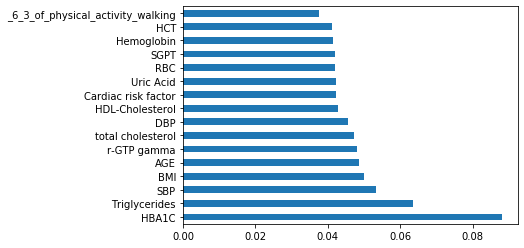

Index(['HBA1C', 'Triglycerides', 'SBP', 'BMI', 'AGE', 'r-GTP gamma',
       'total cholesterol', 'DBP', 'HDL-Cholesterol', 'Cardiac risk factor',
       'Uric Acid', 'RBC', 'SGPT', 'Hemoglobin', 'HCT',
       '_6_3_of_physical_activity_walking', 'blood_type', 'Drinking_5_1_days',
       '_6_2_of_physical_activity_moderate',
       '_6_1_of_physical_activity_high_strength', '_3B_hepatitis'],
      dtype='object')


In [43]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(x,y)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

print(feat_importances.nlargest(21).index)

3.2 SelectKBest method
=========

In [44]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(x,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

# x=x[x.columns[:15]]
print(list(x.columns[:21]))

['HBA1C', 'Triglycerides', 'BMI', 'SBP', 'DBP', 'r-GTP gamma', 'Cardiac risk factor', 'SEX', 'Hemoglobin', 'AGE', 'HCT', 'Uric Acid', 'SGPT', 'RBC', 'total cholesterol', 'HDL-Cholesterol', '_4_1_Smoking', 'Drinking_5_1_days', 'FIELD_6_7', '_6_1_of_physical_activity_high_strength', 'Family_history']


3.3 variance inflation factor 
=============

In [45]:
# this function computes vif value which help us to remove columns with redundant information ( to avoid Multicollinearity)
# Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response.
# Multicollinearity was measured by variance inflation factors (VIF) and tolerance

def vifcal(inputdata,depcol):
    vifL5=[]
    import statsmodels.formula.api as sm
    xvars=inputdata.drop([depcol],axis=1)
    xvarnames=xvars.columns
    for i in range(0,xvarnames.shape[0]):
        _y=xvars[xvarnames[i]]
        _x=xvars[xvarnames.drop(xvarnames[i])]
        rsq=sm.ols(formula="_y~_x",data=xvars).fit().rsquared
        vif=round(1/(1-rsq),2)
        print(i,', ',xvarnames[i]," VIF = ",vif)
        if(vif<5):
            vifL5.append(xvarnames[i])
    return vifL5

In [46]:
# the new columns are selcted from section 3.2

newcols = vifcal(mydata[['HBA1C', 'Triglycerides', 'BMI', 'SBP', 'DBP', 'r-GTP gamma', 'Cardiac risk factor', 
                         'SEX', 'Hemoglobin', 'AGE', 'HCT', 'Uric Acid', 'SGPT', 'RBC', 'total cholesterol', 
                         'HDL-Cholesterol', '_4_1_Smoking', 'Drinking_5_1_days', 
                         '_6_1_of_physical_activity_high_strength', 'Family_history','CLASS']],'CLASS')
print(newcols,len(newcols))

# we need to exclude features with vif value >5


0 ,  HBA1C  VIF =  1.26
1 ,  Triglycerides  VIF =  1.61
2 ,  BMI  VIF =  1.37
3 ,  SBP  VIF =  2.64
4 ,  DBP  VIF =  2.42
5 ,  r-GTP gamma  VIF =  1.38
6 ,  Cardiac risk factor  VIF =  15.11
7 ,  SEX  VIF =  0.0
8 ,  Hemoglobin  VIF =  10.81
9 ,  AGE  VIF =  1.38
10 ,  HCT  VIF =  13.89
11 ,  Uric Acid  VIF =  1.16
12 ,  SGPT  VIF =  1.33
13 ,  RBC  VIF =  2.33
14 ,  total cholesterol  VIF =  7.65
15 ,  HDL-Cholesterol  VIF =  10.6
16 ,  _4_1_Smoking  VIF =  1.06
17 ,  Drinking_5_1_days  VIF =  1.15
18 ,  _6_1_of_physical_activity_high_strength  VIF =  1.02
19 ,  Family_history  VIF =  1.01
['HBA1C', 'Triglycerides', 'BMI', 'SBP', 'DBP', 'r-GTP gamma', 'SEX', 'AGE', 'Uric Acid', 'SGPT', 'RBC', '_4_1_Smoking', 'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength', 'Family_history'] 15


3.4 Final Selected Features
======

In [69]:
# based on the out put of section of 3.2 and 3.3 the following features are selected

finalFeatures=['HBA1C', 'Triglycerides', 'BMI',  'r-GTP gamma', 'SEX', 'AGE', 'Uric Acid', 
               '_4_1_Smoking', 'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength', 'Family_history','CLASS']

Classifier Model Test Based on the features 
========

In [137]:
randomseed=7
mydata=data[finalFeatures].copy().dropna()
print(mydata.shape)
mydata.head()

(142724, 12)


,HBA1C,Triglycerides,BMI,r-GTP gamma,SEX,AGE,Uric Acid,_4_1_Smoking,Drinking_5_1_days,_6_1_of_physical_activity_high_strength,Family_history,CLASS
4,5.18,92.0,23.7,24.0,0.0,50.0,2.8,2.0,3.0,2.0,0.0,1
7,5.30,92.0,25.1,40.0,0.0,46.0,7.9,2.0,6.0,0.0,0.0,0
9,5.40,60.0,18.0,24.0,0.0,46.0,5.6,1.0,1.0,1.0,0.0,0
10,5.50,90.0,18.5,29.0,0.0,47.0,5.6,1.0,1.0,1.0,0.0,0
11,5.53,58.0,19.2,37.0,0.0,48.0,5.6,1.0,1.0,1.0,0.0,0


In [148]:
diabetic = mydata[mydata.CLASS==2]
prediabetic = mydata[mydata.CLASS==1]
normal = mydata[mydata.CLASS==0]

print(diabetic.shape[0],prediabetic.shape[0],normal.shape[0])

2451 36237 104036


In [156]:
diabetic_test = diabetic.sample(500,random_state=randomseed)
prediabetic_test = prediabetic.sample(500,random_state=randomseed)
normal_test = normal.sample(500,random_state=randomseed)
test=pd.concat([diabetic_test,prediabetic_test,normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index).sample(diabetic_train.shape[0],random_state=randomseed)
normal_train = normal.drop(normal_test.index).sample(diabetic_train.shape[0],random_state=randomseed)
train=pd.concat([diabetic_train,prediabetic_train,normal_train])

In [157]:
# # generate synthetic dataset to overcome class imbalance
# from collections import Counter
# from numpy.random import RandomState
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTENC

# sm = SMOTENC(random_state=42, categorical_features=[5, 6, 7, 8])
# X_res, y_res = sm.fit_resample(train.iloc[:,:-1],train.iloc[:,-1])
# print("Resampled dataset samples per class {}".format(Counter(y_res)))

# train=pd.DataFrame(X_res,columns=list(train.columns[:-1]))
# train['CLASS']=y_res

In [158]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=randomseed,n_estimators=100,max_depth=10 )
rf.fit(train.iloc[:,:-1],train.iloc[:,-1])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

0.7233333333333334


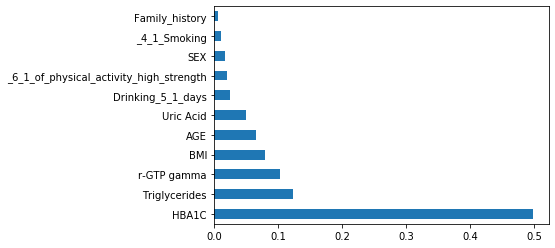

Index(['HBA1C', 'Triglycerides', 'r-GTP gamma', 'BMI', 'AGE', 'Uric Acid',
       'Drinking_5_1_days', '_6_1_of_physical_activity_high_strength', 'SEX',
       '_4_1_Smoking', 'Family_history'],
      dtype='object')


In [159]:
ypred= rf.predict(test.iloc[:,:-1])

score=rf.score(test.iloc[:,:-1],test.iloc[:,-1])
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:,:-1].columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

print(feat_importances.nlargest(16).index)

In [160]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test.iloc[:,-1],ypred)

array([[352, 138,  10],
       [128, 318,  54],
       [  6,  79, 415]], dtype=int64)

In [161]:
print("Accuracy on training set: {:.3f}".format(rf.score(train.iloc[:,:-1],train.iloc[:,-1])))
print("Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:,:-1],test.iloc[:,-1] ))) 
ypred=rf.predict(test.iloc[:,:-1])

confmatrx=pd.DataFrame(confusion_matrix(test.iloc[:,-1],ypred))
confmatrx.head()


Accuracy on training set: 0.857
Accuracy on test set: 0.723


,0,1,2
0,352,138,10
1,128,318,54
2,6,79,415


In [162]:

from sklearn.metrics import classification_report 
print(classification_report(test.iloc[:,-1], ypred))


              precision    recall  f1-score   support

           0       0.72      0.70      0.71       500
           1       0.59      0.64      0.61       500
           2       0.87      0.83      0.85       500

    accuracy                           0.72      1500
   macro avg       0.73      0.72      0.73      1500
weighted avg       0.73      0.72      0.73      1500



In [163]:
import xgboost as xgb
from sklearn import metrics as m
xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=randomseed,num_class = 3)

xgb_model.fit(train.iloc[:,:-1],train.iloc[:,-1])

y_pred = xgb_model.predict((test.iloc[:,:-1]))

print('accuracy \t',m.accuracy_score(test.iloc[:,-1],y_pred))
confmatrx=pd.DataFrame(confusion_matrix(test.iloc[:,-1],y_pred))
confmatrx.head()

accuracy 	 0.73


,0,1,2
0,351,141,8
1,116,323,61
2,8,71,421


In [164]:
print(classification_report(test.iloc[:,-1], y_pred))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       500
           1       0.60      0.65      0.62       500
           2       0.86      0.84      0.85       500

    accuracy                           0.73      1500
   macro avg       0.73      0.73      0.73      1500
weighted avg       0.73      0.73      0.73      1500



===============================
==========

In [167]:
import pickle

with open('DiabeticClassifierModel', 'wb') as f:
    pickle.dump(xgb_model, f)


# # to load saved model file   
# with open('DiabeticClassifierModel', 'rb') as f:
#     rf = pickle.load(f)

# preds_loaded = rf.predict(test[features])